## Use join_frogs to create new training df, while doing EDA on it

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Data science
import pandas as pd
import numpy as np
# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray
# Import Planetary Computer tools
import fsspec
import pystac
# Other
import os
import zipfile
from itertools import cycle

import folium
from itertools import cycle
import contextily as cx
data_path = '../'

output_path = './output/'

In [2]:
# Read in stuff we're gonna join
# read in the stuff we need to join. Read in as dataarray, not as dataset, so that we can use .rename('data')
weather_data1 = xr.open_dataarray('weather_data_1012.nc')
weather_data2 = xr.open_dataarray('weather_data_1314.nc')
weather_data3 = xr.open_dataarray('weather_data_1516.nc')
weather_data4 = xr.open_dataarray('weather_data_17.nc')
weather_data5 = xr.open_dataarray('weather_data_18.nc')
weather_data6 = xr.open_dataarray('weather_data_1920.nc')
frogs = pd.concat([pd.read_csv('pseudo_absence_fixed.csv'),pd.read_csv('pseudo_absence_region5.csv')])
frogs['species'] = 'pseudo'
frogs = frogs.rename(columns = {'latitude':'decimalLatitude','longitude':'decimalLongitude'})#.sample(10000,random_state = 0)

# Check that this covers test regions
print('min Long: ', frogs['decimalLongitude'].min(), ' max Long: ', frogs['decimalLongitude'].max())
print('min Lat: ', frogs['decimalLatitude'].min(), ' max Lat: ', frogs['decimalLatitude'].max())

min Long:  112.00016000000004  max Long:  134.99990000730048
min Lat:  -34.99882999999963  max Lat:  -9.9003599926996


In [59]:
pd.read_csv('30kfrogs.csv').head()

,Unnamed: 0.1,Unnamed: 0,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,coordinateUncertaintyInMeters,occurrenceStatus,key
0,0,25984,3463687745,2020-03-21 00:00:00,Australia,Australia,New South Wales,-35.493347,150.369076,Crinia Signifera,30.0,0,0
1,1,183108,3108896846,2019-11-01 00:00:00,Australia,Australia,New South Wales,-35.946277,148.626597,Crinia Signifera,5.0,0,1
2,2,45457,3463551873,2020-10-07 00:00:00,Australia,Australia,New South Wales,-35.377700,149.206000,Crinia Signifera,9.8,0,2
3,3,172113,1071431690,2014-10-11 00:00:00,Australia,Australia,New South Wales,-32.986010,150.893219,Crinia Signifera,3.0,0,3
4,4,134046,3108871450,2018-07-09 00:00:00,Australia,Australia,New South Wales,-33.763524,151.237485,Crinia Signifera,5.0,0,4


In [6]:
frogs['key'] = range(0,len(frogs))

In [63]:
frogs

,Unnamed: 0,decimalLatitude,decimalLongitude,species,key
0,0,-18.44997,115.41705,pseudo,0
1,1,-20.71741,113.68505,pseudo,1
2,2,-12.39905,114.02710,pseudo,2
3,3,-13.90167,130.13468,pseudo,3
4,4,-11.97327,122.75401,pseudo,4
...,...,...,...,...,...
1995,1995,-32.93431,114.34656,pseudo,31995
1996,1996,-32.37222,115.59630,pseudo,31996
1997,1997,-31.67588,115.94759,pseudo,31997
1998,1998,-32.87327,115.61056,pseudo,31998


In [4]:
# Define the function we're gonna use
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 
    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (data.rename('data').sel(
                x=xr.DataArray(frogs.decimalLongitude, dims="key", coords={"key": frogs.key}), 
                y=xr.DataArray(frogs.decimalLatitude, dims="key", coords={"key": frogs.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

### Try to join from 2015 to 2020

In [7]:
joined = join_frogs(join_frogs(join_frogs(join_frogs(frogs, weather_data3), weather_data4),weather_data5),weather_data6)
# gives 19752 datapoints, Lat (-34, -9.9), Long(113,134)

In [9]:
joined = joined.dropna().sample(n= 12455, random_state = 0)
joined.describe()

,Unnamed: 0,decimalLatitude,decimalLongitude,key,aet_mean_x,def_mean_x,pet_mean_x,ppt_mean_x,q_mean_x,srad_mean_x,...,def_mean_y,pet_mean_y,ppt_mean_y,q_mean_y,srad_mean_y,tmax_mean_y,tmin_mean_y,vap_mean_y,vpd_mean_y,ws_mean_y
count,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,...,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000
mean,14325.324769,-23.089857,125.584657,15847.604978,33.181774,147.318657,180.459006,35.719269,2.499836,249.313693,...,185.213562,197.502890,13.146213,1.005908,261.158103,32.682307,18.490983,1.046143,2.760926,3.246103
std,9007.528825,5.061045,6.026245,9158.247739,20.660555,32.952288,19.457888,23.138661,3.363613,10.450184,...,38.863401,26.046275,17.618787,3.523519,10.401603,3.235757,3.205395,0.416685,0.696688,0.698738
min,0.000000,-34.987150,113.012670,3.000000,11.208333,29.208333,96.500000,11.791667,0.500000,206.458333,...,45.166667,99.833333,0.916667,0.000000,219.083333,19.650002,8.583337,0.520000,0.489167,1.416667
25%,6313.500000,-27.038115,120.560010,7986.000000,18.291667,133.958333,171.291667,19.208333,0.958333,243.854167,...,167.000000,181.791667,4.000000,0.083333,253.750000,30.725001,15.966668,0.764167,2.375833,2.775000
50%,14247.000000,-23.406210,126.180420,15852.000000,25.916667,158.000000,183.666667,27.250000,1.375000,250.958333,...,196.750000,202.333333,5.666667,0.250000,261.833333,33.283336,19.300001,0.872500,2.840000,3.216667
75%,22152.500000,-19.369635,130.833165,23834.000000,39.083333,170.354167,192.875000,42.875000,2.458333,258.125000,...,210.916667,214.625000,12.666667,0.583333,270.000000,35.083335,21.083336,1.209167,3.271667,3.783333
max,29999.000000,-9.904960,134.999300,31999.000000,108.041667,193.750000,215.000000,138.791667,44.458333,263.541667,...,241.750000,244.666667,111.083333,79.000000,278.583333,38.191669,26.408335,2.879167,3.920833,5.883333


In [74]:
joined[['aet_mean_x','aet_mean_y']]

,aet_mean_x,aet_mean_x,aet_mean_y,aet_mean_y
21735,15.916667,15.833333,17.000000,4.083333
12659,26.916667,17.916667,23.083333,3.250000
27443,71.541667,67.750000,70.000000,32.083333
30313,54.041667,47.000000,61.000000,45.500000
30659,40.375000,34.833333,44.666667,31.750000
...,...,...,...,...
16469,14.750000,14.583333,15.750000,5.000000
20076,27.625000,14.750000,17.583333,2.416667
11432,19.500000,22.583333,21.416667,6.583333
20309,46.833333,43.666667,72.666667,23.000000


### Which step went wrong? Try to join using data from 2019-2020 only

In [10]:
joined2 = join_frogs(frogs,weather_data6).dropna().drop(['ws_mean','def_mean','q_mean','vpd_mean'],axis = 1)
joined2

,Unnamed: 0,decimalLatitude,decimalLongitude,species,key,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean
3,3,-13.90167,130.13468,pseudo,3,66.916667,160.916667,67.750000,258.416667,33.008334,20.683334,2.054167
6,6,-29.65332,131.99947,pseudo,6,4.833333,196.083333,5.000000,248.000000,28.983334,13.541667,0.812500
9,9,-21.68846,130.00848,pseudo,9,3.333333,221.000000,3.500000,275.416667,35.075001,19.816668,0.764167
10,10,-12.18266,132.36810,pseudo,10,86.666667,160.000000,89.833333,242.833333,32.375001,21.550002,2.463333
11,11,-24.85567,113.90577,pseudo,11,10.166667,194.500000,10.750000,262.416667,30.458336,19.250002,1.381667
...,...,...,...,...,...,...,...,...,...,...,...,...
31990,1990,-33.62565,116.28854,pseudo,31990,39.666667,118.750000,44.166667,235.333333,22.216668,8.883336,1.100000
31993,1993,-31.07303,117.96472,pseudo,31993,14.750000,153.250000,15.666667,244.750000,25.966668,12.341668,1.008333
31994,1994,-33.85017,115.11325,pseudo,31994,59.416667,120.416667,64.416667,228.666667,20.933336,12.025002,1.243333
31997,1997,-31.67588,115.94759,pseudo,31997,39.583333,146.166667,45.916667,247.000000,24.225001,12.366668,1.242500


In [11]:
df = joined2.sample(n=12455,random_state = 42)
df['occurrenceStatus'] = 0
print('min Long: ', df['decimalLongitude'].min(), ' max Long: ', df['decimalLongitude'].max())
print('min Lat: ', df['decimalLatitude'].min(), ' max Lat: ', df['decimalLatitude'].max())

min Long:  113.01267000032144  max Long:  134.9986700073001
min Lat:  -34.9895999999967  max Lat:  -9.901069992699824


In [103]:
df

,Unnamed: 0,decimalLatitude,decimalLongitude,species,key,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,occurrenceStatus
19005,19005,-20.46374,124.05100,pseudo,19005,4.916667,220.000000,5.083333,273.250000,36.875001,22.050002,1.015000,0
21096,21096,-24.85400,123.06385,pseudo,21096,3.750000,227.916667,4.000000,258.416667,34.133334,19.083335,0.836667,0
31325,1325,-33.69345,116.76102,pseudo,31325,26.000000,121.333333,30.416667,234.250000,22.283335,9.533336,1.085000,0
16212,16212,-19.42935,126.66346,pseudo,16212,3.250000,227.000000,3.333333,276.333333,36.816668,21.975000,0.950000,0
13600,13600,-23.32588,126.31857,pseudo,13600,2.916667,241.916667,3.083333,267.833333,35.558336,20.775002,0.720833,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27490,27490,-20.12754,125.44579,pseudo,27490,2.750000,224.583333,2.833333,275.416667,37.516668,22.391666,0.972500,0
9309,9309,-22.23907,113.90255,pseudo,9309,8.666667,202.000000,9.166667,262.083333,31.458335,18.425001,1.555833,0
29759,29759,-19.73758,129.12261,pseudo,29759,4.000000,218.833333,4.166667,276.916667,35.208335,19.941668,0.804167,0
6994,6994,-29.13519,129.14086,pseudo,6994,5.000000,205.500000,5.416667,250.166667,29.500001,13.858335,0.834167,0


In [12]:
# Load in previous traning set
df_pre = pd.read_csv('climate_frog1220_7vars.csv')
df_pre.groupby('occurrenceStatus').count()

,Unnamed: 0.1,Unnamed: 0,gbifID,eventDate,stateProvince,decimalLatitude,decimalLongitude,species,coordinateUncertaintyInMeters,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,year,month,key
occurrenceStatus,,,,,,,,,,,,,,,,,,,
0,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911
1,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911,24911


#### So there are 24911 presence, 24911 true absence, and 10000 pseudo absence
#### we will first combine, then class balance, then visualize

In [13]:
all_absent = pd.concat([df_pre[df_pre['occurrenceStatus'] ==0][['occurrenceStatus', 'decimalLatitude','decimalLongitude','species',
                                                                'aet_mean', 'pet_mean', 'ppt_mean', 'srad_mean','tmax_mean', 
                                                                'tmin_mean', 'vap_mean']], 
                        df[['occurrenceStatus', 'decimalLatitude','decimalLongitude','species',
                            'aet_mean', 'pet_mean', 'ppt_mean', 'srad_mean','tmax_mean', 'tmin_mean', 'vap_mean']]])
all_present = df_pre[df_pre['occurrenceStatus'] ==1][[ 'occurrenceStatus','decimalLatitude','decimalLongitude','species',
                                                      'aet_mean', 'pet_mean', 'ppt_mean', 'srad_mean', 'tmax_mean', 
                                                      'tmin_mean', 'vap_mean']]
print(all_absent.shape,all_present.shape)
train = pd.concat([all_absent,all_present])

(37366, 11) (24911, 11)


**This is the difference between pseudo & true absent classes**

<AxesSubplot:xlabel='species', ylabel='srad_mean'>

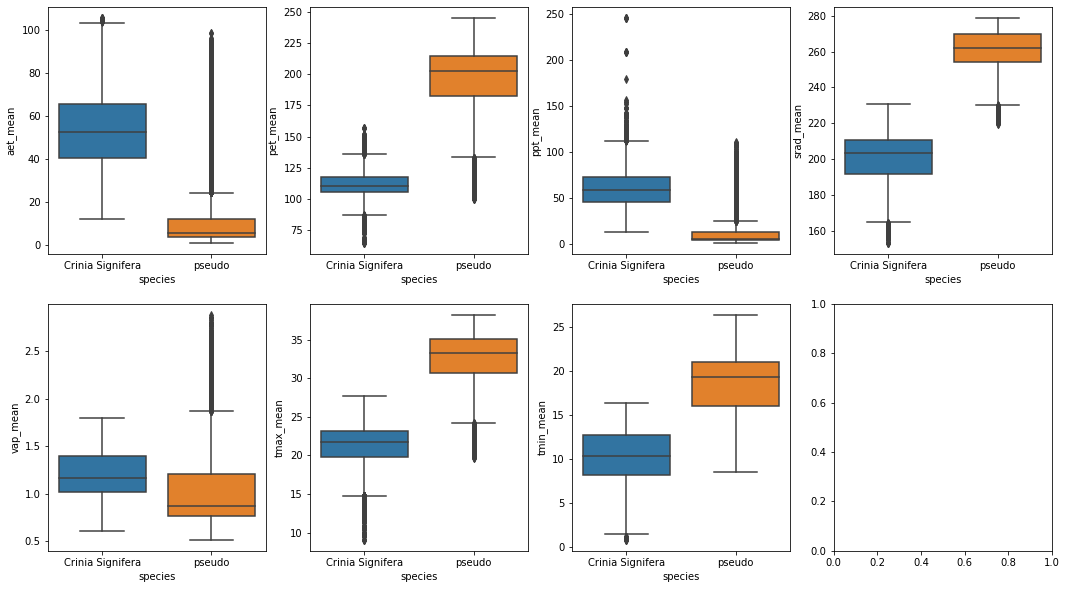

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.boxplot(ax = axes[0,0], data = train[train['occurrenceStatus'] ==0], x = 'species', y = 'aet_mean')
sns.boxplot(ax = axes[0,1], data = train[train['occurrenceStatus'] ==0], x = 'species', y = 'pet_mean')
sns.boxplot(ax = axes[0,2], data = train[train['occurrenceStatus'] ==0], x = 'species',  y = 'ppt_mean')
sns.boxplot(ax = axes[1,0], data = train[train['occurrenceStatus'] ==0], x = 'species',  y = 'vap_mean')
sns.boxplot(ax = axes[1,1], data = train[train['occurrenceStatus'] ==0], x = 'species',  y = 'tmax_mean')
sns.boxplot(ax = axes[1,2], data = train[train['occurrenceStatus'] ==0], x = 'species', y = 'tmin_mean')
sns.boxplot(ax = axes[0,3], data = train[train['occurrenceStatus'] ==0], x = 'species',  y = 'srad_mean')

**This is the difference between classes after combining pseudo & true absence data**

min Long:  113.10813000035174  max Long:  153.63
min Lat:  -43.426497  max Lat:  -9.901069992699824


<AxesSubplot:xlabel='occurrenceStatus', ylabel='srad_mean'>

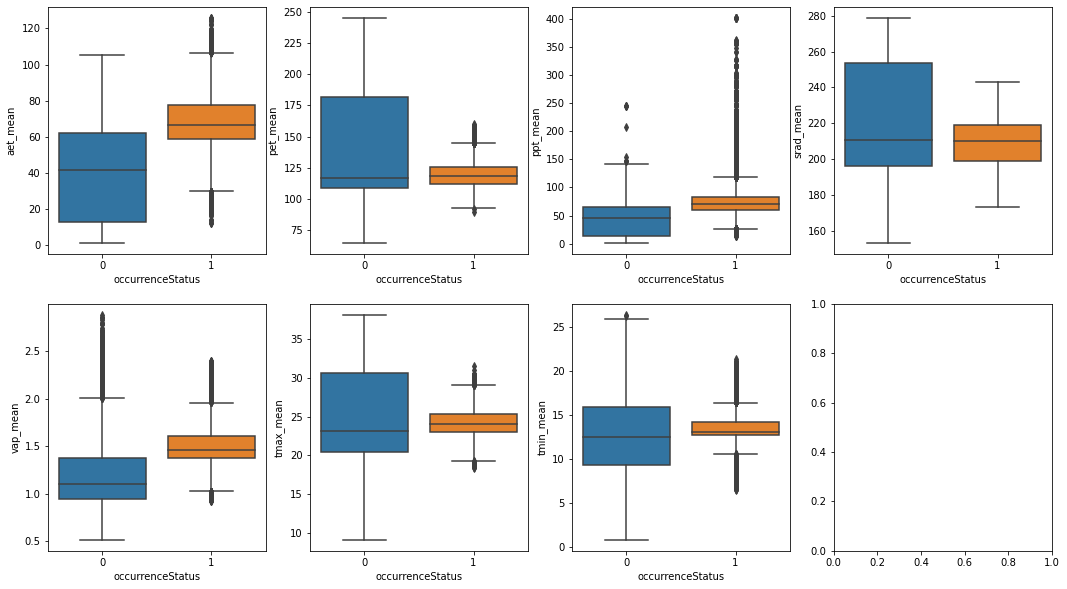

In [15]:
# Down sample the absence class
train2 = pd.concat([all_absent.sample(n= 24911,random_state = 0),all_present])

# ensure test region 5 is inside
temp = train2[train2['occurrenceStatus'] == 0]
print('min Long: ', temp['decimalLongitude'].min(), ' max Long: ', temp['decimalLongitude'].max())
print('min Lat: ', temp['decimalLatitude'].min(), ' max Lat: ', temp['decimalLatitude'].max())

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.boxplot(ax = axes[0,0], data = train2, x= 'occurrenceStatus',  y = 'aet_mean')
sns.boxplot(ax = axes[0,1], data = train2, x= 'occurrenceStatus', y = 'pet_mean')
sns.boxplot(ax = axes[0,2], data = train2, x= 'occurrenceStatus',  y = 'ppt_mean')
sns.boxplot(ax = axes[1,0], data = train2, x= 'occurrenceStatus',  y = 'vap_mean')
sns.boxplot(ax = axes[1,1], data = train2, x= 'occurrenceStatus',  y = 'tmax_mean')
sns.boxplot(ax = axes[1,2], data = train2, x= 'occurrenceStatus', y = 'tmin_mean')
sns.boxplot(ax = axes[0,3], data = train2, x= 'occurrenceStatus',  y = 'srad_mean')

### This is our final training data! Save to csv

In [16]:
train2.to_csv('climate_frog1220_7vars_pseudo2.csv')